In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm
import cv2
import tifffile
from skimage.transform import resize
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, Reshape, Input, Conv2DTranspose
from keras.layers import Activation, LeakyReLU, BatchNormalization, Dropout, Resizing
import dcgan as dcgan
import wgan as wgan
import prgan as prgan

from fid_score import calculate_fid
from fid_score import preprocess_array

try:
    from tensorflow.keras.optimizers import Adam
except:
    from keras.optimizers import Adam



In [2]:
NOISE_DIM = 100  
BATCH_SIZE = 20 
STEPS_PER_EPOCH = 100
EPOCHS = 2
STEPS = 1
SEED = 40
WIDTH, HEIGHT, CHANNELS = 75, 75, 2
OPTIMIZER = Adam(0.0002, 0.5)

In [3]:
train = pd.read_json('./data/train.json')
train['inc_angle'] = pd.to_numeric(train['inc_angle'],errors='coerce')

In [ ]:
def get_stats(train,label=1):
    train['max'+str(label)] = [np.max(np.array(x)) for x in train['band_'+str(label)] ]
    train['maxpos'+str(label)] = [np.argmax(np.array(x)) for x in train['band_'+str(label)] ]
    train['min'+str(label)] = [np.min(np.array(x)) for x in train['band_'+str(label)] ]
    train['minpos'+str(label)] = [np.argmin(np.array(x)) for x in train['band_'+str(label)] ]
    train['med'+str(label)] = [np.median(np.array(x)) for x in train['band_'+str(label)] ]
    train['std'+str(label)] = [np.std(np.array(x)) for x in train['band_'+str(label)] ]
    train['mean'+str(label)] = [np.mean(np.array(x)) for x in train['band_'+str(label)] ]
    train['p25_'+str(label)] = [np.sort(np.array(x))[int(0.25*75*75)] for x in train['band_'+str(label)] ]
    train['p75_'+str(label)] = [np.sort(np.array(x))[int(0.75*75*75)] for x in train['band_'+str(label)] ]
    train['mid50_'+str(label)] = train['p75_'+str(label)]-train['p25_'+str(label)]

    return train
train = get_stats(train,1)
train = get_stats(train,2)

In [ ]:
def plot_var(name,nbins=50):
    minval = train[name].min()
    maxval = train[name].max()
    plt.hist(train.loc[train.is_iceberg==1,name],range=[minval,maxval],
             bins=nbins,color='b',alpha=0.5,label='Boat')
    plt.hist(train.loc[train.is_iceberg==0,name],range=[minval,maxval],
             bins=nbins,color='r',alpha=0.5,label='Iceberg')
    plt.legend()
    plt.xlim([minval,maxval])
    plt.xlabel(name)
    plt.ylabel('Number')
    plt.show()

In [ ]:
for col in ['inc_angle','min1','max1','std1','med1','mean1','mid50_1']:
    plot_var(col)

In [ ]:
train_stats = train.drop(['id','is_iceberg','band_1','band_2'],axis=1)

In [ ]:
corr = train_stats.corr()
fig = plt.figure(1, figsize=(10,10))
plt.imshow(corr,cmap='inferno')
labels = np.arange(len(train_stats.columns))
plt.xticks(labels,train_stats.columns,rotation=90)
plt.yticks(labels,train_stats.columns)
plt.title('Correlation Matrix of Global Variables')
cbar = plt.colorbar(shrink=0.85,pad=0.02)
plt.show()

In [4]:
icebergs = train[train.is_iceberg==1].sample(n=300,random_state=123)
ships = train[train.is_iceberg==0].sample(n=300,random_state=456)

In [ ]:
# Plot band_1/band_2 images
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(icebergs.iloc[i,1]),(75,75))
    ax.imshow(arr,cmap='inferno')
    
plt.show()

In [ ]:
def plot_results(images, n_cols=None):
    '''Visualizes fake images'''

    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(n_cols * 2, n_rows * 2))  # Increase the figure size to accommodate 2-band images

    for index, image in enumerate(images):
        if image.shape[-1] == 1:
            image = np.squeeze(image, axis=-1)
        elif image.shape[-1] == 2:
            # Merge the two bands into a single image
            image = np.dstack((image[:, :, 0], image[:, :, 1]))
            image = np.mean(image, axis=2)  # Convert to grayscale by taking the mean of the two bands
        else:
            raise ValueError("Invalid number of image bands")

        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="inferno")
        plt.axis("off")


In [5]:
# download the training images
X_train = icebergs[['band_1', 'band_2']]
# Remove the first row (column names)
column_names = X_train.iloc[0]
X_train = X_train.iloc[1:]

column_1 = np.array([np.array(image) for image in X_train['band_1']])
column_2 = np.array([np.array(image) for image in X_train['band_2']])

column_1 = column_1.flatten().reshape(-1)
column_2 = column_2.flatten().reshape(-1)

mean_1 = np.mean(column_1)
std_1 = np.std(column_1)

mean_2 = np.mean(column_2)
std_2 = np.std(column_2)

normalized_column_1 = (column_1 - column_1.min()) / (column_1.max() - column_1.min())
normalized_column_2 = (column_2 - column_2.min()) / (column_2.max() - column_2.min())
#normalized_column_1 = (column_1 - mean_1) / std_1
#normalized_column_2 = (column_2 - mean_2) / std_2

X_train_normalized = np.column_stack((normalized_column_1, normalized_column_2))
#print(X_train[0])
# Reshape images 
X_train = X_train_normalized.reshape(-1, WIDTH,HEIGHT,CHANNELS)

# Convert X_train to a NumPy array
X_train_array = np.array(X_train)


print(X_train_array.shape)

# create batches of tensors to be fed into the model
dataset = X_train
print(X_train_array.dtype)

(299, 75, 75, 2)
float64


In [6]:
def sample_images(noise, subplots, generator, prefix, figsize=(22,8), save=False):
    generated_images = generator.predict(noise)
    plt.figure(figsize=figsize)
    #print(np.amax(generated_images))
    samples = []
    for i, image in enumerate(generated_images):
        plt.subplot(subplots[0], subplots[1], i+1)
        if CHANNELS == 1:
            plt.imshow(image.reshape((WIDTH, HEIGHT)), cmap='gray')    
                                                                            
        else:
            image_band1 = np.reshape(np.array(image[:, :, 1]),(75,75))
            plt.imshow(image_band1, cmap='inferno')

            #channel_1 = image[:, :, 0]
            #channel_2 = image[:, :, 1]

            #plt.subplot(1, 2, 1)
            #plt.imshow(channel_1, cmap='gray')
            #plt.title('Channel 1')

            #plt.subplot(1, 2, 2)
            #plt.imshow(channel_2, cmap='gray')
            #plt.title('Channel 2')

            #plt.show()
            import matplotlib.image
            #print(np.amin(image.reshape((WIDTH, HEIGHT, 3))))
            from skimage import util
            #image = (image - image.min()) / (image.max() - image.min())
            #print(np.min(image))   # minimum value of the image data
            #print(np.max(image))   # maximum value of the image data
            #matplotlib.image.imsave('gen_img'+str(i)+'.png', image)
            #image_data = np.transpose(image, (2, 0, 1))
            # Transpose the array to have shape (height, width, num_channels)
            #image_data = np.transpose(image, (2, 0, 1))
            #print(image.shape)
            # Concatenate the channels along the third axis to create a multi-channel image
            print(image.shape)
            joined_channels_image = np.concatenate([np.expand_dims(image[:, :, i], axis=0) for i in range(image.shape[2])], axis=0)
            joined_channels_image = np.transpose(joined_channels_image, (1, 2, 0))  # Transpose dimensions

            samples.append(joined_channels_image)
            combined_image = np.mean(joined_channels_image, axis=2)

            plt.imshow(combined_image, cmap='inferno')
            # Save grayscale image as PNG
            plt.imsave(prefix + '_gen_img' + str(i) + '.png', combined_image, cmap='inferno')

        if save == True:
            img_name = "gen" + str(i)
            plt.savefig(img_name)
        plt.subplots_adjust(wspace=None, hspace=None)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    return samples

In [ ]:
noise_dcgan = np.random.normal(0,1, size=(BATCH_SIZE, NOISE_DIM))
noise_wgan = tf.random.normal([32, 75*75*2])
generator_dcgan, discriminator_dcgan, dcgan_model = dcgan.build(OPTIMIZER, NOISE_DIM)
generator_dcgan_loss_values = dcgan.train(generator_dcgan, discriminator_dcgan, dcgan_model, noise_dcgan, EPOCHS, STEPS, BATCH_SIZE, NOISE_DIM, X_train_array)
generator_wgan, generator_wgan_loss_values = wgan.train(EPOCHS, STEPS, BATCH_SIZE, NOISE_DIM, X_train_array)


In [7]:
generator_prgan, generator_prgan_loss_values = prgan.build(X_train_array)

C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Scaled Data (75, 4, 4, 2)
1/1 [==============================] - 0s 157ms/step
>1, d1=0.003, d2=0.005 g=-0.001
1/1 [==============================] - 0s 24ms/step
>2, d1=-0.021, d2=0.014 g=-0.007
1/1 [==============================] - 0s 24ms/step
>3, d1=-0.041, d2=0.030 g=-0.018
1/1 [==============================] - 0s 23ms/step
>4, d1=-0.056, d2=0.054 g=-0.033
1/1 [==============================] - 0s 27ms/step
>Saved: plot_004x004-tuned.png and model_004x004-tuned.h5
Scaled Data (75, 8, 8, 2)
1/1 [==============================] - 0s 138ms/step
>1, d1=-0.066, d2=0.460 g=0.070
1/1 [==============================] - 0s 23ms/step
>2, d1=0.106, d2=0.044 g=0.030
1/1 [==============================] - 0s 24ms/step
>3, d1=0.126, d2=0.003 g=0.295
1/1 [==============================] - 0s 25ms/step
>4, d1=0.106, d2=0.033 g=0.024
1/1 [==============================] - 0s 36ms/step
>Saved: plot_008x008-faded.png and model_008x008-faded.h5
1/1 [==============================] - 0s 116ms/step
>

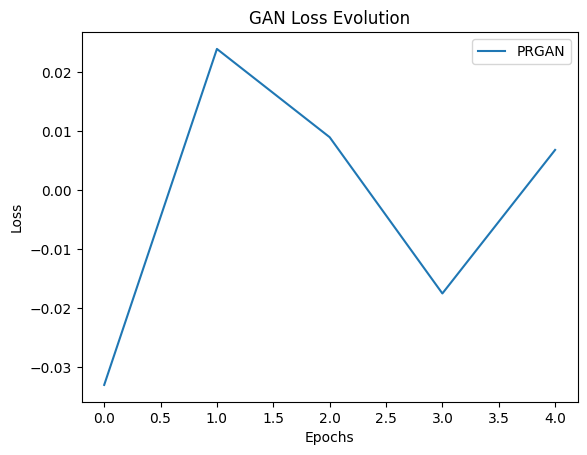

In [8]:
import matplotlib.pyplot as plt

# Plotting the loss values for Model 1
#plt.plot(discriminator_loss_model1, label='Model 1 - Discriminator Loss')
#plt.plot(generator_dcgan_loss_values, label='DCGAN')

# Plotting the loss values for Model 2
#plt.plot(discriminator_loss_model2, label='Model 2 - Discriminator Loss')
#plt.plot(generator_wgan_loss_values, label='WGAN')


#plt.plot(discriminator_loss_model2, label='Model 2 - Discriminator Loss')
plt.plot(generator_prgan_loss_values, label='PRGAN')

# Adding labels and title to the plot
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GAN Loss Evolution')

# Adding a legend
plt.legend()

# Displaying the plot
plt.show()

In [10]:
#noise_dcgan = np.random.normal(0, 1, size=(100, NOISE_DIM))
#noise_wgan = tf.random.normal([32, 75*75*2])
noise_prgan = randn(100 * 16)
# reshape into a batch of inputs for the network
noise_prgan = noise_prgan.reshape(16, 100)

#samples_dcgan = sample_images(noise_dcgan, (10,10), generator_dcgan, 'dcgan', (24,20), save=True)
#samples_wgan = sample_images(noise_wgan, (10,10), generator_wgan, 'wgan', (24,20), save=True)
samples_prgan = sample_images(noise_prgan, (10,10), generator_prgan, 'wgan', (24,20), save=True)

InvalidArgumentError: Graph execution error:

Detected at node 'model_8/dense_1/BiasAdd' defined at (most recent call last):
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\flopes1\AppData\Local\Temp\ipykernel_24228\3343599672.py", line 6, in <module>
      samples_prgan = sample_images(noise_prgan, (10,10), generator_prgan, 'wgan', (24,20), save=True)
    File "C:\Users\flopes1\AppData\Local\Temp\ipykernel_24228\3348187957.py", line 2, in sample_images
      generated_images = generator.predict(noise)
    File "C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 2350, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 2137, in predict_function
      return step_function(self, iterator)
    File "C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 2123, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 2111, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 2079, in predict_step
      return self(x, training=False)
    File "C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\layers\core\dense.py", line 252, in call
      outputs = tf.nn.bias_add(outputs, self.bias)
Node: 'model_8/dense_1/BiasAdd'
Matrix size-incompatible: In[0]: [32,32], In[1]: [100,2048]
	 [[{{node model_8/dense_1/BiasAdd}}]] [Op:__inference_predict_function_19951]

In [ ]:
samples_dcgan_array = np.array(samples_dcgan)
samples_wgan_array = np.array(samples_wgan)
X_train_array = np.array(X_train)

samples_dcgan_array = preprocess_array(samples_dcgan_array)
samples_wgan_array = preprocess_array(samples_wgan_array)
X_train_array = preprocess_array(X_train_array)

print(calculate_fid(X_train_array[:10], samples_dcgan_array[:10]))
print(calculate_fid(X_train_array[:10], samples_wgan_array[:10]))